In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sachinperimbeti","key":"0f02925d91b2dbedfd026269407cfeb2"}'}

In [5]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Aug 20 06:24 kaggle.json


In [6]:
!pip install -q kaggle

In [7]:
!mkdir -p ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!pwd

/content


In [11]:
!kaggle competitions list

ref                                                                                     deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         1,100,000 Usd        756           False  
https://www.kaggle.com/competitions/isic-2024-challenge                                 2024-09-06 23:59:00  Research            80,000 Usd       2311           False  
https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification  2024-10-08 23:59:00  Featured            50,000 Usd       1064           False  
https://www.kaggle.com/competitions/ariel-data-challenge-2024                           2024-10-31 23:59:00  Featured            50,000 Usd        263     

In [12]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:46<00:00, 24.6MB/s]
100% 6.31G/6.31G [04:46<00:00, 23.7MB/s]


In [13]:

%pip install keras

In [14]:
#import libraries

#general libraries
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
import shutil

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [15]:
tf.__version__

'2.17.0'

In [16]:
!unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [17]:
train_dir = '/content/train'
test_dir = '/content/test'
sample_submission = pd.read_csv('/content/sample_submission.csv')
train_labels = pd.read_csv('/content/train_labels.csv')

In [18]:
# declare constants for reproduciblity
RANDOM_STATE = 49

In [ ]:
#test_path = test_dir
#train_path = train_dir
#sample_submission = sample_submission
#train_data = train_labels

### **Describing the Problem**

Each file in the dataset is a TIFF image, characterized by dimensions of 96x96 pixels and 3 color channels, with pixel values ranging from 0 to 255. This presents a particular challenge, as TIFF files are not natively supported by the Keras framework, in contrast to more commonly supported formats such as PNG or JPEG. The dataset comprises a substantial collection of 220,025 labeled images, where each image is categorized as either 0 or 1. A label of 1 indicates the presence of cancerous cells, while a label of 0 signifies the absence of such cells.

Each image in the dataset is accompanied by a unique identifier and an associated label in a provided dataframe. The data is already partitioned into training and testing subsets: the training set includes 220,025 images, and the test set contains approximately 57,500 images. According to the competition guidelines, an image is classified as cancerous (label 1) if at least one pixel within the image is identified as cancerous; otherwise, it is classified as non-cancerous (label 0). Notably, the dataset is complete with no missing values, facilitating more streamlined data preprocessing.

In [19]:



print("\n----- Format of data-----")
print(train_labels.head())
print("\n----- Further look into data -----")
print(train_labels.describe())

print("\n----- Check Info, Data Types and Missing Values-----")
print(train_labels.info())

print("\n----- Null counts -----")
null_counts = train_labels.isna().sum()
print(null_counts)


----- Format of data-----
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

----- Further look into data -----
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

----- Check Info, Data Types and Missing Values-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

----- Null counts -----
id       0
label    0
dtype: int64


# **Exploratory Data Analysis**

Below are sample images from the training dataset. For those unacquainted with identifying cancer cells or analyzing such images, classifying these might be quite challenging. To address this, each image is accompanied by its corresponding label to facilitate accurate identification.  Furthermore, it is noted that each image contains potentially cancerous cells centered within a 32x32 pixel region. To emphasize this focal area, we have highlighted it with a red box.





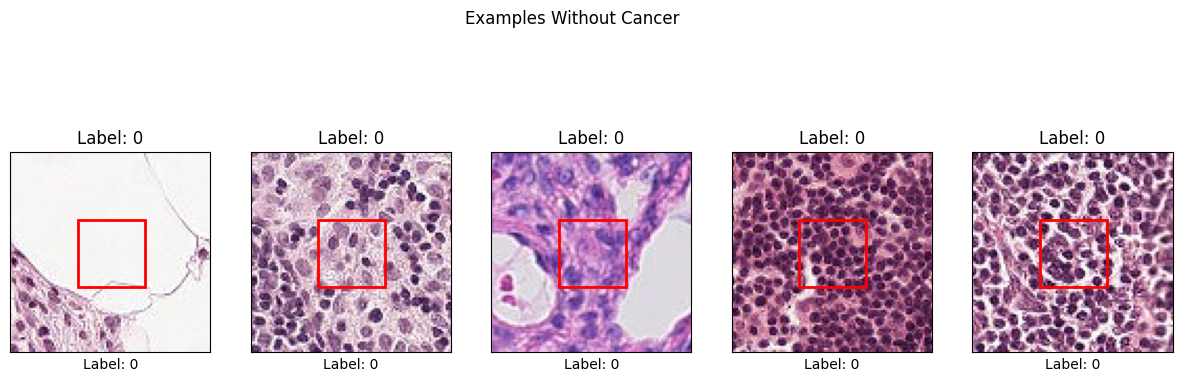

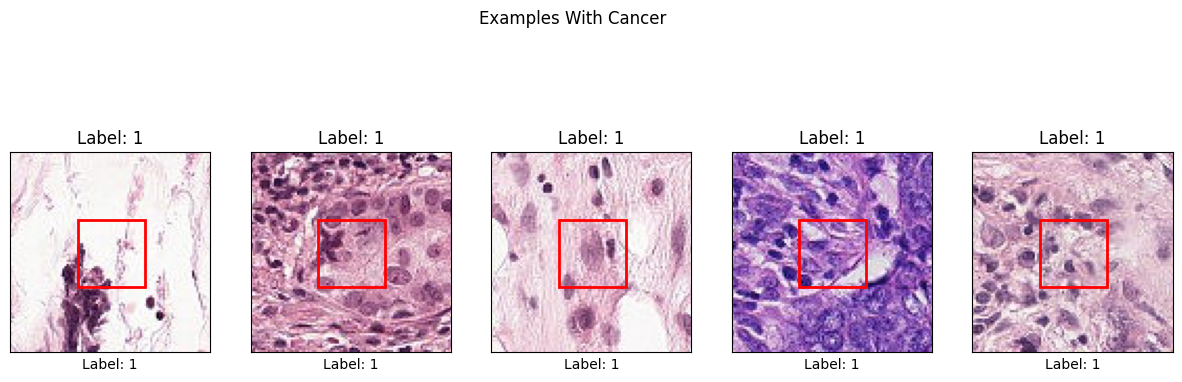

In [ ]:
from PIL import Image



# Visualize some of the images
def show_images(ids, labels, path, title):
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(ids), i + 1)
        plt.imshow(img)

        # Adding bounding box
        box = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(box)

        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f"Label: {label}")
        plt.title(f"Label: {label}")

    plt.suptitle(title)
    plt.show()

# Showing 5 examples of images without cancer
show_images(train_labels[train_labels['label'] == 0]['id'][:5], [0]*5, train_dir, "Examples Without Cancer")

# Showing 5 examples of images with cancer
show_images(train_labels[train_labels['label'] == 1]['id'][:5], [1]*5, train_dir, "Examples With Cancer")

Sample image dimensions: (96, 96)
Number of channels in the sample image: RGB




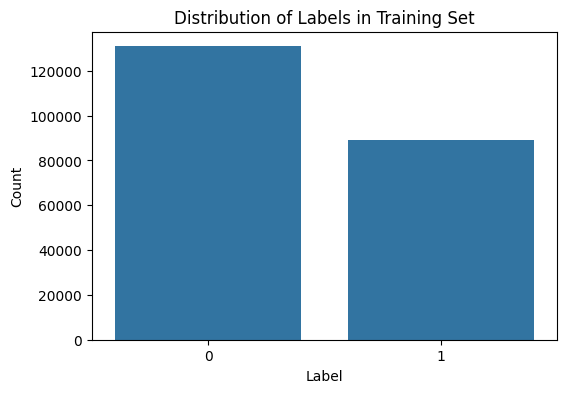

In [ ]:
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
sample_image = Image.open(sample_image_path)
print(f"Sample image dimensions: {sample_image.size}")
print(f"Number of channels in the sample image: {sample_image.mode}\n\n")

# Print the number of positive and negative samples in the training set
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
#create pie chart
fig = px.pie(train_labels,
             values = train_labels['label'].value_counts().values,
             names = train_labels['label'].unique())
fig.update_layout(
    title={
        'text': "Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


The histogram and pie chart reveal a distribution where 59.5% of the images are labeled as 0 (non-cancerous) and 40.5% as 1 (cancerous). Although the competition description suggests a balanced dataset with a 50/50 split between cancerous and non-cancerous images, our analysis indicates a discrepancy, with a closer approximation to a 40/60 distribution. This indicates an imbalance in the data, though not to a severe extent, especially when compared to more pronounced imbalances such as 30/70 or 10/90 splits. Given that we have a substantial number of images available for training, this level of imbalance should be manageable. Consequently, we can reasonably expect to develop a robust model capable of effectively identifying cancerous images.

### Preprocess/Clean Data


When preparing our training data, the initial step involves addressing any missing values. Based on our review and the provided information, we confirm that the training set is complete with no missing data. Our focus will be on the central region of each image, as indicated by the red box in the diagram. The current image dimensions are 96x96x3, with "3" representing the RGB color channels. We will retain this format for now.

Additionally, while various image augmentations can enhance model performance and learning, we will initially refrain from applying these techniques to maintain simplicity.

To ensure that the model's training is not influenced by the sequence or pattern of the images, we will shuffle the dataset. Furthermore, we will partition the data into training and validation sets to support effective model development. During training, we will normalize the pixel values by dividing them by 255.0, which will aid in data processing and contribute to the model's training efficiency.

# **DModel Architecture**

We will utilize the Keras library to implement a convolutional neural network (CNN) for this model. Initially, we’ll run a basic version of the model without adjusting any hyperparameters to establish a baseline. Subsequently, we'll create a second model where we fine-tune various hyperparameters, including the learning rate, batch normalization, regularization, filter size, stride, activation functions, and more.

Our CNN architecture will consist of two convolutional layers followed by a MaxPooling layer, with this sequence repeated a specified number of times. In particular, we’ll design a straightforward model with two such clusters (n=2). This means our network structure will be: input → Conv2D → Conv2D → MaxPool → Conv2D → Conv2D → MaxPool → Flatten → output with sigmoid activation.

### First Model
For the first Model, this is the role of each parameter

1.   **Image Normalization**: Each pixel value is divided by 255 to scale the data within a 0-1 range.
2.   **Output Layer Activation**: A sigmoid function is applied to the output layer, suitable for binary classification tasks.



Additionally, we will train this model with relatively large batch sizes of 256 to reduce variance. This model will be trained for 10 epochs, with performance evaluated using accuracy, the ROC-AUC curve, and binary cross-entropy as the loss function.



In [20]:
# set model constants
BATCH_SIZE = 256

In [21]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_labels["id"] = train_labels["id"].apply(append_tif)
train_labels['label'] = train_labels['label'].astype(str)

# randomly shuffle training data
train_labels = shuffle(train_labels, random_state=RANDOM_STATE)

In [22]:
# modify training data by normalizing it
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [23]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))        # original image = (96, 96)

Found 187022 validated image filenames belonging to 2 classes.


In [24]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))       # original image = (96, 96)

Found 33003 validated image filenames belonging to 2 classes.


In [25]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### Building Model 1

This model is relatively straightforward, consisting of several layers but lacking activation functions apart from the final layer. For the output layer, we employ a sigmoid activation function to accommodate our binary classification task (0 or 1). The following code snippet details the architecture of the model and the number of trainable parameters. In the subsequent cell, you will find the training progress of the model over each epoch.

In [ ]:


# use GPU
with strategy.scope():

    #create model
    model_one = Sequential()

    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))

    #build model by input size
    model_one.build(input_shape=(BATCH_SIZE, 64, 64, 3))        # original image = (96, 96, 3)

    # set ROC AUC as metric
    ROC_1 = tf.keras.metrics.AUC()

    #compile
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])

#quick look at model
model_one.summary()
print(model_one.summary())

NameError: name 'strategy' is not defined

In [ ]:
EPOCHS = 10

# train the model
history_model_one = model_one.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



 57/731 ━━━━━━━━━━━━━━━━━━━━ 6:37 590ms/step - accuracy: 0.5793 - auc: 0.5656 - loss: 0.7674

KeyboardInterrupt: 

With the model training complete, we can visually assess its performance on the training data. The graphs below display the accuracy and loss metrics for both the validation and training datasets.

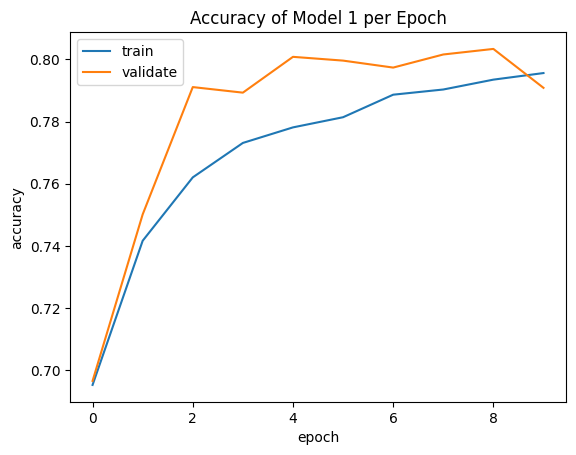

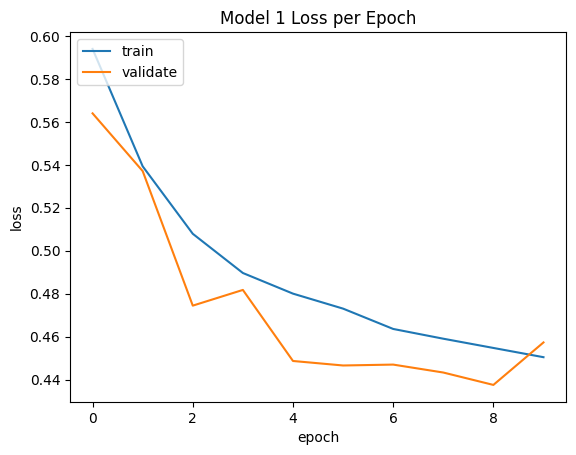

In [ ]:
# plot model accuracy per epoch
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Accuracy of Model 1 per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model 1 Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Building Model 2

For our Second Model, it inherits the parameters of the first model with additional parameters

1.   **Image Normalization**: Each pixel value is divided by 255 to scale the data within a 0-1 range.
2.   Output Layer Activation: A sigmoid function is applied to the output layer, suitable for binary classification tasks.

3.   **Dropout**: We set the dropout rate to 0.1, randomly deactivating some weights during training to regularize the model by limiting the number of active weights in each iteration.
4.  **Optimization**: The Adam optimizer, which simulates momentum by adjusting gradients and their squares, is employed to enhance the training process.
5. **Learning Rate**: A learning rate of 0.0001 is chosen to control the speed of learning during gradient descent, helping the model to gradually approach the global minimum without overshooting.
6. **Hidden Layer Activations**: ReLU is used in the hidden layers to improve convergence, prevent saturation, and minimize computational demands.





Additionally, we will train with relatively large batch sizes of 256 to reduce variance. The model will be trained for 10 epochs, with performance evaluated using accuracy, the ROC-AUC curve, and binary cross-entropy as the loss function.

In our second model, we’ve implemented hyperparameter optimization. The model utilizes ReLU activation for the hidden layers, includes dropout between layers, and integrates batch normalization. Additionally, we introduced an extra hidden layer before the flattening and output layers. Finally, the model is optimized using the Adam algorithm with a reduced learning rate.








In [26]:
# build second model like first but with hyperparameters and optimizer(s)
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():

    #create model
    model_two = Sequential()

    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))

    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(AveragePooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))

    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))

    #build model by input size
    model_two.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3)

    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

#quick look at model
model_two.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (256, 62, 62, 16)           │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (256, 60, 60, 16)           │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (256, 30, 30, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (256, 30, 30, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (256, 30, 30, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (256, 28, 28, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (256, 26, 26, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (256, 13, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (256, 13, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (256, 13, 13, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (256, 11, 11, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (256, 3872)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (256, 1)                    │           3,873 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,969 (117.07 KB)

 Trainable params: 29,873 (116.69 KB)

 Non-trainable params: 96 (384.00 B)

In [27]:
EPOCHS = 10

# train model
history_model_two = model_two.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


731/731 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step - accuracy: 0.7455 - auc: 0.8077 - loss: 0.5155 - val_accuracy: 0.7129 - val_auc: 0.8861 - val_loss: 0.7855
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 133s 180ms/step - accuracy: 0.8255 - auc: 0.8924 - loss: 0.4018 - val_accuracy: 0.7837 - val_auc: 0.9031 - val_loss: 0.5358
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 132s 179ms/step - accuracy: 0.8338 - auc: 0.9036 - loss: 0.3836 - val_accuracy: 0.8230 - val_auc: 0.9113 - val_loss: 0.4343
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 132s 180ms/step - accuracy: 0.8414 - auc: 0.9119 - loss: 0.3680 - val_accuracy: 0.8328 - val_auc: 0.9199 - val_loss: 0.3974
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 132s 179ms/step - accuracy: 0.8483 - auc: 0.9194 - loss: 0.3545 - val_accuracy: 0.8584 - val_auc: 0.9271 - val_loss: 0.3421
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 132s 179ms/step - accuracy: 0.8590 - auc: 0.9295 - loss: 0.3319 - val_accuracy: 0.8294 - val_auc: 0.9233 - val_loss: 0.4253
Epoch 7/10
731/731 ━━━━━━━━

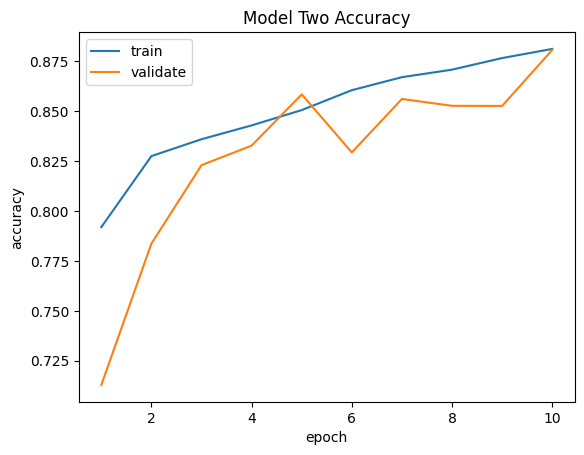

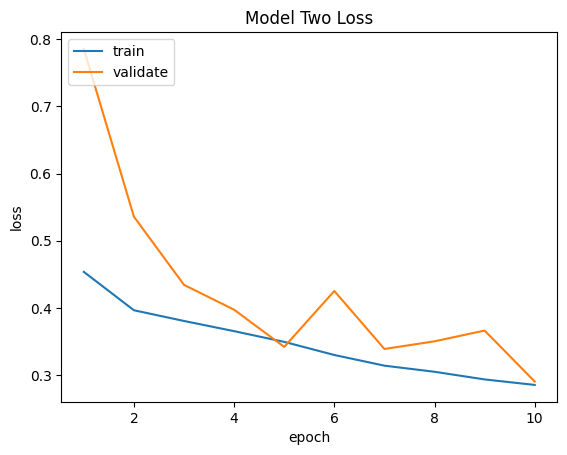

In [28]:
# graph loss
plt.plot(np.arange(1,len(history_model_two.history['accuracy']) + 1), history_model_two.history['accuracy'])
plt.plot(np.arange(1,len(history_model_two.history['val_accuracy']) + 1),history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(np.arange(1,len(history_model_two.history['loss']) + 1),history_model_two.history['loss'])
plt.plot(np.arange(1,len(history_model_two.history['val_loss']) + 1),history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [29]:
#double check what you're aiming the submission data set to look like
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [31]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test_dir)})
test_df.head()

,id
0,33d58354a3598837a104104745703737167c4055.tif
1,73a5d9c2ea8868f47831ddd0cdd8a032b0b87276.tif
2,2e016176844bc7c538f7b87a192fbeb3cb18007b.tif
3,25a4db6178c4643768cfec2cd51ffbf018bd1c3c.tif
4,c35d75d62b7a9e37f3a2a7d8722580b44a272977.tif


In [32]:
# prepare test data (in same way as train data)
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(64,64),         # original image = (96, 96)
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [33]:
#run model to find predictions

# predictions = model_one.predict(test_generator, verbose=1)
predictions = model_two.predict(test_generator, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step


In [ ]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

In [ ]:
#view test prediction counts
submission_df['label'].value_counts()

In [ ]:
#plot test predictions
sns.countplot(data=submission_df, x='label').set(title='Predicted Labels for Test Set');

In [ ]:

#convert to csv to submit to competition
submission_df.to_csv('submission.csv', index=False)

# **Results**

The plots and diagrams provided earlier illustrate the performance of both models on the training and validation datasets. Model one, in particular, showed more stable results in terms of the ROC metric, compared to the more intricate model two. However, neither model displayed consistent accuracy, loss, or ROC stabilization, especially in model two. This could likely be attributed to the limited number of epochs (10) and the simplicity of the CNN architecture, which might require more extensive training to fully converge given the large volume of images.

Upon evaluating both models on the test set individually, the results align with expectations. Model one, which lacks hyperparameter tuning, underperformed relative to model two. Conversely, model two achieved a respectable score of around 0.80, reflecting a solid performance considering the simplicity of the models we constructed.

# **Conclusion**

The first model was fairly straightforward, without any hyperparameter tuning, while the second model involved more detailed adjustments and additional layers. Both models were trained over 10 epochs, and despite their simplicity, they performed reasonably well. As anticipated, the second model outperformed the first, demonstrating the positive impact of hyperparameter tuning when applied effectively.

To further enhance these models, several strategies could be employed. Firstly, training the model with augmented images could be beneficial. In the preprocessing step, we only normalized the images, but augmenting them by applying transformations like flipping, zooming, stretching, and rotating could expose the model to a wider variety of image instances, improving its learning. However, due to time and memory constraints, this approach wasn't explored in this notebook. Additionally, extending the number of epochs might allow the model to learn more effectively, though care must be taken to avoid overfitting. Since this project serves a demonstration purpose, we opted not to increase the epochs.

Other potential improvements include (1) using transfer learning by incorporating components from a pre-trained model, (2) exploring hyperparameter tuning more thoroughly by adjusting parameters like strides, filter size, activation functions, and learning rate, and (3) designing a more complex model with additional layers. While it's difficult to predict which specific adjustments would yield significantly better results without testing them, these suggestions offer promising directions for further experimentation in future iterations.